# Read

The data of the selected pairs to trade.

In [ ]:
import models
import numpy as np
import pandas as pd

from data import *

In [2]:
filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)
display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,SPY_ETF,AVAXUSDT,0.869979,-3.278551,0.015865,True,-3.598971,0.024574,True
3,SPY_ETF,ETHUSDT,0.890225,-3.433397,0.009872,True,-3.693317,0.018691,True
4,EQQQ_ETF,BNBUSDT,0.898875,-3.915881,0.001921,True,-3.961015,0.008155,True
5,BNBUSDT,ADAUSDT,0.892662,-3.052379,0.030284,True,-3.509109,0.031596,True
6,BNBUSDT,ETHUSDT,0.921440,-3.114948,0.025467,True,-3.432310,0.038886,True
7,BNBUSDT,TRXUSDT,0.945392,-3.996231,0.001430,True,-4.200755,0.003638,True
8,BNBUSDT,XRPUSDT,0.931496,-4.213361,0.000625,True,-4.639767,0.000715,True
9,TRXUSDT,XRPUSDT,0.933322,-3.358503,0.012458,True,-3.623223,0.022926,True


We have the following pairs to trade:
- GOOG - GOOGL: Google Series A and Google Series C - since both securities depict the performance of the same company, we do not want to consider this pair in our portfolio
- META - DAX ETF
- S&P 500 ETF and AVAXUDST: S&P 500 ETF and Avalanche cryptocurrency
- S&P 500 ETF and ETHUDST: S&P 500 ETF and Ethereum cryptocurrency
- EQQQ ETF and BNBUSDT: Nasdaq 100 ETF and Binance coin cryptocurrency
- BNBUSDT and ADAUSDT: Binance coin and Cardano cryptocurrency
- BNBUSDT and ETHUDST: Binance coin and Ethereum cryptocurrency
- BNBUSDT and TRXUDST: Binance coin and TRON cryptocurrency
- BNBUSDT and XRPUDST: Binance coin and XRP (Ripple) cryptocurrency
- TRXUDST and XRPUDST: TRON cryptocurrency and XRP (Ripple) cryptocurrency.

As we can see, the portfolio is composed mostly of cryptocurrencies, but there is also an equity pair (Meta/DAX ETF) as well as equity-cryptocurrency pairs: S&P 500 ETF/Avalanche and S&P 500 ETF/Ethereum. Such a composition, in hindsight, should not come as a surprise because:
- Numerous cryptocurrency pairs are driven by similar factors and in this market events on all tradeable coins are still mostly driven by Bitcoin, hence high correlations and time-invariant spreads are fairly expected
- Equity-cryptocurrency pairs: S&P 500 ETF against Avalanche and Ethereum reflect the increasing interest in and integration of the traditional financial markets and digital assets
- The equity-equity pair Meta/DAX ETF suggests a potential macroeconomic link: Meta is a global tech giant while DAX represents the broader European market; hence these two correlating may be drien by similar trends and/or risk sentiments.

In [3]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
df_full = pd.read_csv('df_full.csv').drop(['Unnamed: 0'], axis=1)
df_full = df_full[df_full['Symbol'].isin(unique_tickers)].copy().reset_index(drop=True)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT ETHUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
TRXUSDT XRPUSDT
********************
Unique tickers:
META
SPY_ETF
EQQQ_ETF
BNBUSDT
TRXUSDT
DAXEX_ETF
AVAXUSDT
ETHUSDT
ADAUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
108691,2024-11-26 05:05:00,41.4200,41.7300,41.3600,41.5800,AVAXUSDT
93457,2024-11-17 09:30:00,35.9500,36.0300,35.9100,36.0100,AVAXUSDT
154224,2024-12-22 13:30:00,0.8944,0.8958,0.8920,0.8923,ADAUSDT
127451,2024-12-07 01:35:00,2.4261,2.4410,2.4238,2.4367,XRPUSDT
42858,2024-10-19 02:45:00,0.3541,0.3543,0.3536,0.3537,ADAUSDT


## Prepare Spreads of the Final Pairs

Once we have the pairs series prepared and aligned in time, we can proceed with spread calculation. Spread between two assets at time $t$ is given directly as the difference between two asset prices, i.e., $$\text{Spread}_{AB, t} = p_{A,t} - p_{B, t}$$ where $p_A$ - price of asset A and $p_B$ - price of asset B.

The next step is to normalize the spread by subtracting the mean and dividing by standard deviation, given as $$\text{Normalized Spread}_t = \frac{\text{Spread}_{AB, t} - \mu_{\text{Spread}_{AB}}}{\sigma_{\text{Spread}_{AB}}}$$

In the base case scenario, a **trading signal** is identified when spread is below -2 or above 2 with the following interpretation:
- $\text{Spread}_{AB, t} < -2$: buy A, sell B
- $\text{Spread}_{AB, t} > 2$: buy B, sell A.

## Additional Considerations

Our trading strategy will work flawlessly if there is always a sequence of events:
1. *Signal* Buy 1 unit of asset A, sell 1 unit of asset B.
2. No action for $n$ periods.
3. *Signal* Sell 1 unit of asset A, buy 1 unit of asset B.

However, in reality, we cannot assume that such a scenario will always occur. Below we have listed some exceptions and how we have handled them:
- A sequence of consecutive trading signals in the next $k$ forecasts: due to the assumption of next-period-opening-price execution (we are unable to open a position at the same tick that feeds the forecast), we must consider the scenario in which we receive more than one trading signal in a row and how we manage the positions. The possibilities are as follows:
    - *First signal entry*: immediate reaction resulting in increasing our exposure on assets A and B until the exposure limit has been reached, which we discuss in the next point; ensures timely reaction to the forecast, but may lead to unnecessarily frequent trades and transaction costs;
    - *Last signal entry*: waiting until the sequence of trading signals is interrupted by a 'No action' forecast; reduces information noise but may execute trades at less favorable prices;
    - *Threshold-based confirmation*: entering a trade only after receiving $m$ trading subsequent signals, e.g., $m=3$; similarly to last signal entry, it helps avoid information noise, but may lead to less favorable execution; this approach 
- Risk management with respect to portfolio asset allocation: having up to 10 unique assets (assuming all trading pairs have generated signals within the same time frame), we must take certain measures to ensure diversification and avoid overexposure to a single asset by assuming that we limit the exposure to any single asset to **25%** of the total portfolio value.
- Trending spread instead of mean reversion: we can forcefully close the position if the spread does not generate an opposite trading signal within $X$ periods
- Conflicting trading signals: it is possible that while on the pair A-B there is a long/short signal, on the pair A-C there is a short/long signal and the position on A would net to 0. Such a situation can be observed in the Forex market and we are allowing it in this project.

<u>**NOTE**</u> Currently Ridge Regression adds 5 lags of normalized spread to have some features for modeling.

Ridge Regression MSE: 0.01782673148316417


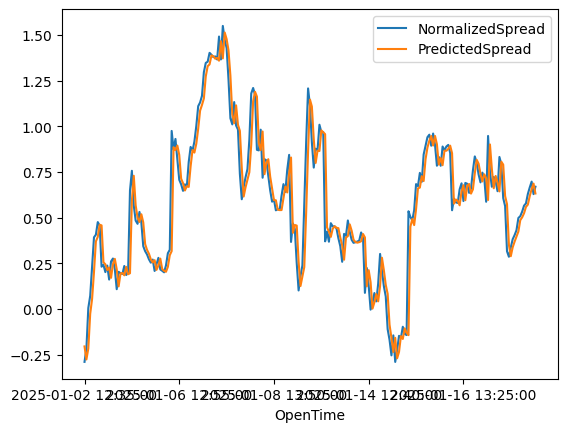

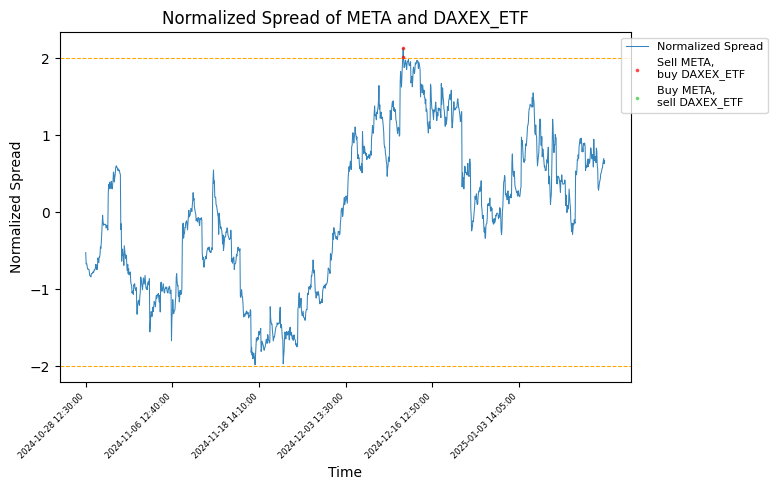

,META,DAXEX_ETF,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-28 12:30:00,580.450,162.10,418.350,-0.524746,No action
2024-10-28 12:35:00,577.670,162.10,415.570,-0.671628,No action
2024-10-28 13:00:00,577.755,162.04,415.715,-0.663967,No action
2024-10-28 13:10:00,577.320,162.08,415.240,-0.689064,No action
2024-10-28 13:20:00,576.615,162.12,414.495,-0.728426,No action


Ridge Regression MSE: 0.024691441210215093


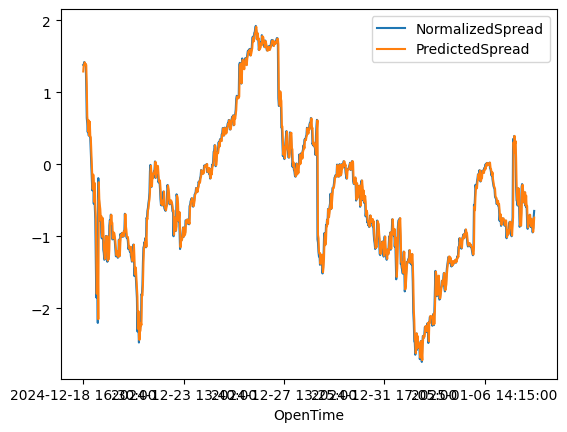

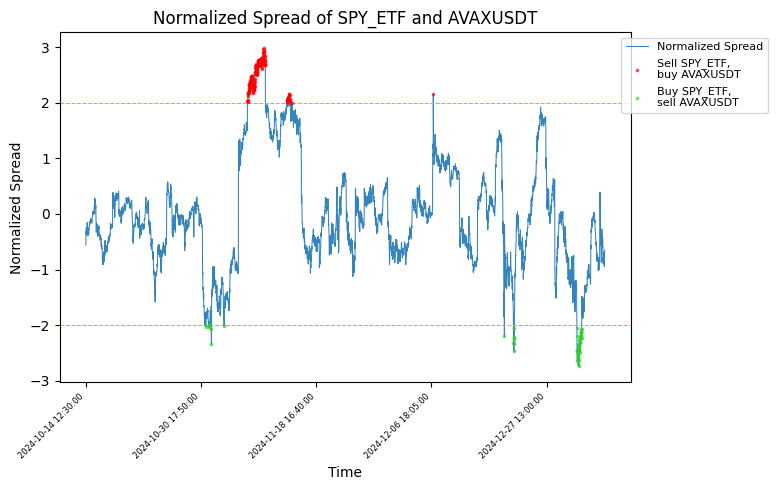

,SPY_ETF,AVAXUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,581.80,29.17,552.63,-0.555976,No action
2024-10-14 12:35:00,581.86,29.17,552.69,-0.544138,No action
2024-10-14 12:40:00,582.14,29.20,552.94,-0.494814,No action
2024-10-14 12:45:00,583.03,29.15,553.88,-0.309355,No action
2024-10-14 12:50:00,582.76,29.17,553.59,-0.366571,No action


Ridge Regression MSE: 0.00152430793867656


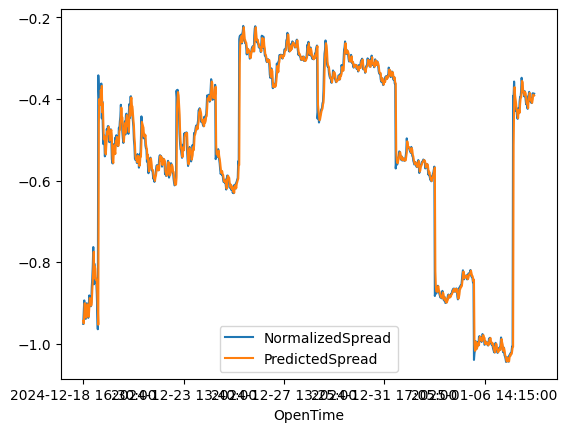

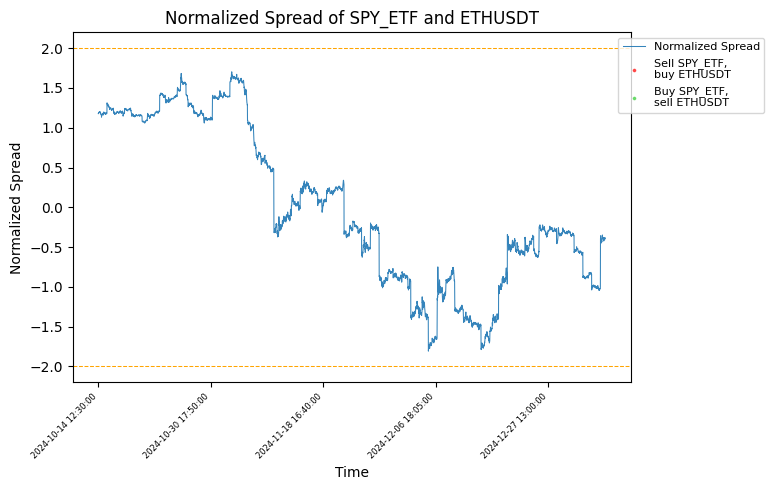

,SPY_ETF,ETHUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,581.80,2627.09,-2045.29,1.177548,No action
2024-10-14 12:35:00,581.86,2625.69,-2043.83,1.180623,No action
2024-10-14 12:40:00,582.14,2626.97,-2044.83,1.178517,No action
2024-10-14 12:45:00,583.03,2625.72,-2042.69,1.183023,No action
2024-10-14 12:50:00,582.76,2623.80,-2041.04,1.186497,No action


Ridge Regression MSE: 0.0021076392674875388


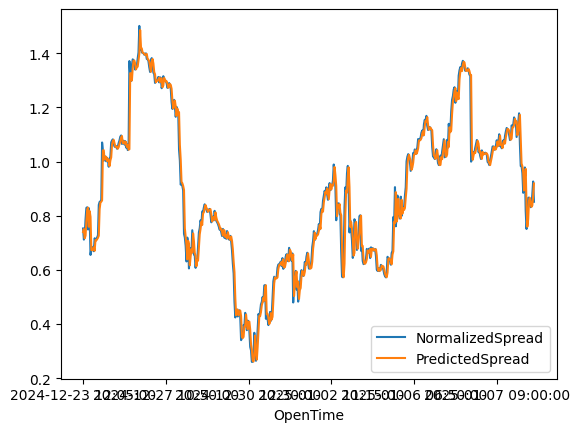

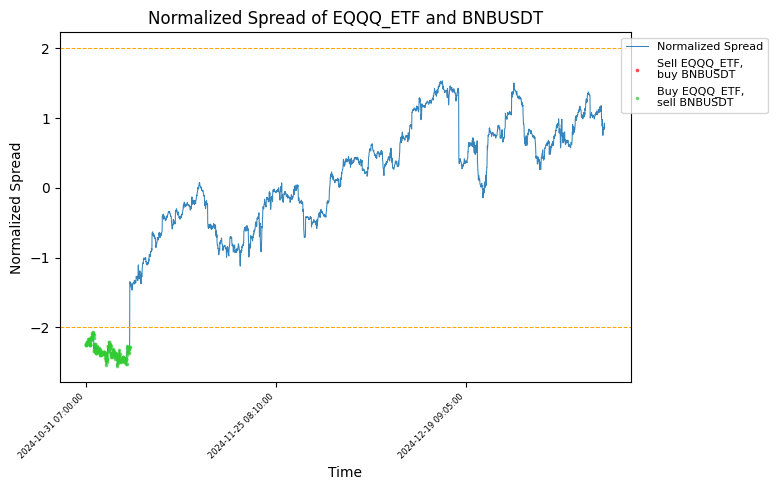

,EQQQ_ETF,BNBUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-31 07:00:00,37990.0,578.2,37411.8,-2.248889,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:05:00,38001.0,580.1,37420.9,-2.241156,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:10:00,37986.0,579.0,37407.0,-2.252968,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:25:00,38011.0,579.6,37431.4,-2.232233,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:35:00,37978.0,577.9,37400.1,-2.258832,"Buy EQQQ_ETF, sell BNBUSDT"


Ridge Regression MSE: 0.00040377835920174277


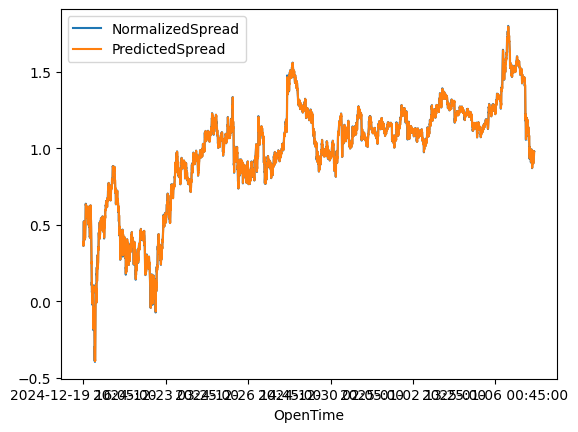

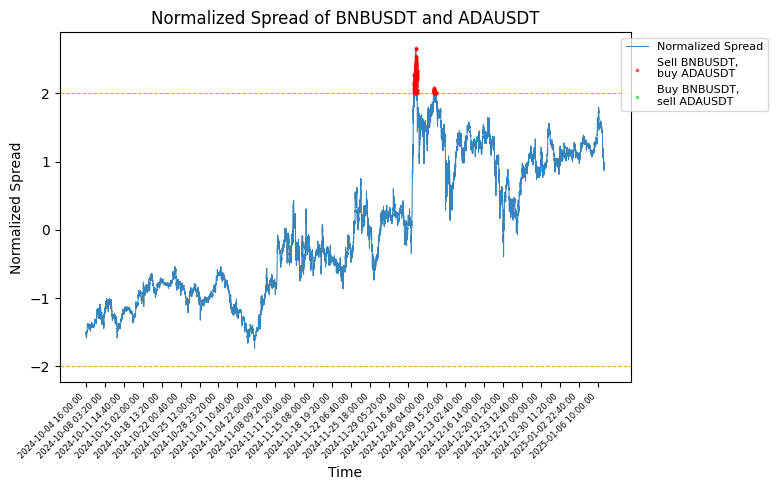

,BNBUSDT,ADAUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.3521,555.9479,-1.520989,No action
2024-10-04 16:05:00,556.5,0.3523,556.1477,-1.517447,No action
2024-10-04 16:10:00,556.0,0.3523,555.6477,-1.526310,No action
2024-10-04 16:15:00,555.9,0.3523,555.5477,-1.528082,No action
2024-10-04 16:20:00,555.5,0.3515,555.1485,-1.535158,No action


Ridge Regression MSE: 0.000163348457851236


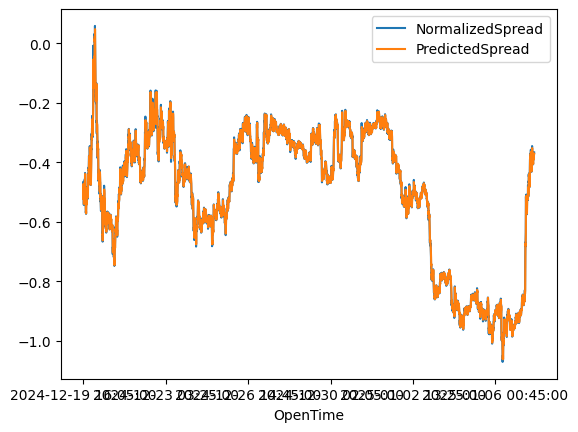

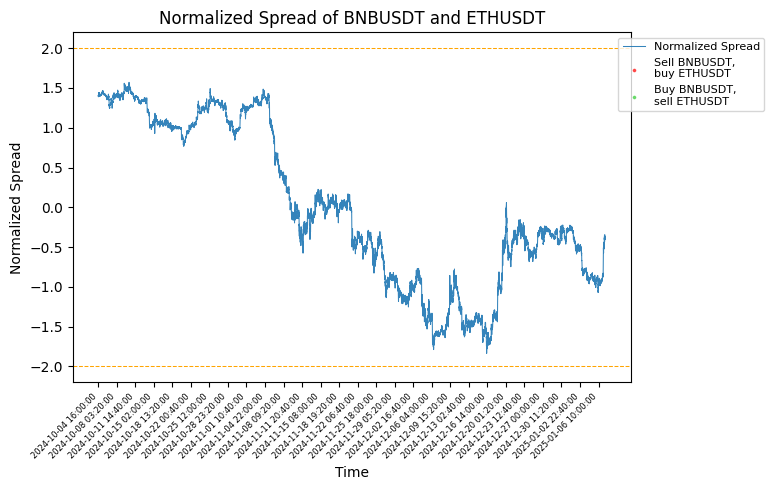

,BNBUSDT,ETHUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,2420.21,-1863.91,1.397404,No action
2024-10-04 16:05:00,556.5,2420.40,-1863.90,1.397426,No action
2024-10-04 16:10:00,556.0,2415.90,-1859.90,1.406057,No action
2024-10-04 16:15:00,555.9,2414.47,-1858.57,1.408927,No action
2024-10-04 16:20:00,555.5,2413.27,-1857.77,1.410653,No action


Ridge Regression MSE: 0.0004017319295498797


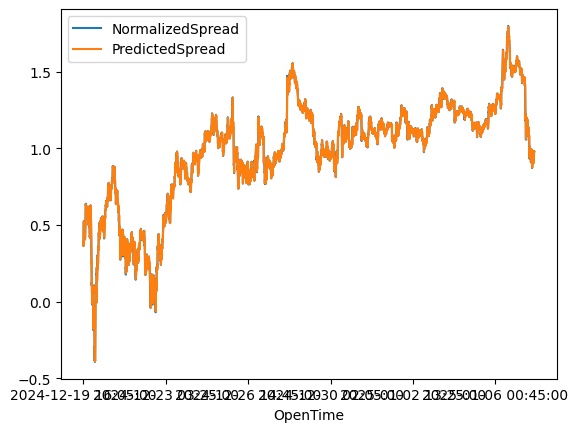

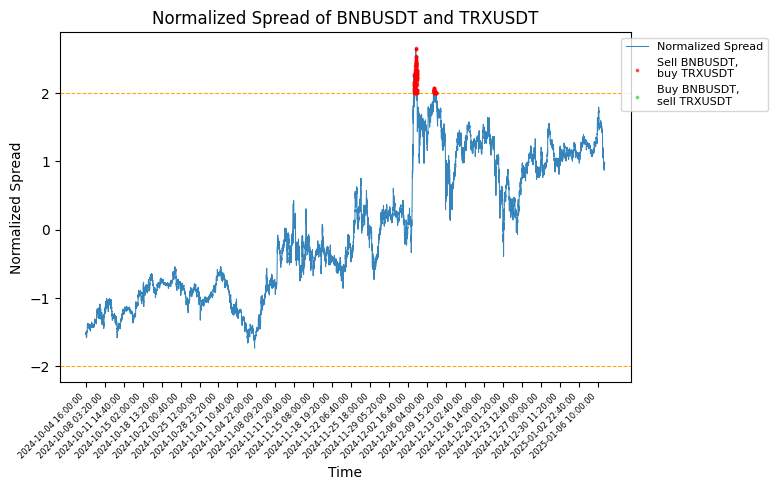

,BNBUSDT,TRXUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.1566,556.1434,-1.520241,No action
2024-10-04 16:05:00,556.5,0.1566,556.3434,-1.516711,No action
2024-10-04 16:10:00,556.0,0.1566,555.8434,-1.525537,No action
2024-10-04 16:15:00,555.9,0.1564,555.7436,-1.527298,No action
2024-10-04 16:20:00,555.5,0.1564,555.3436,-1.534358,No action


Ridge Regression MSE: 0.00040897641484479526


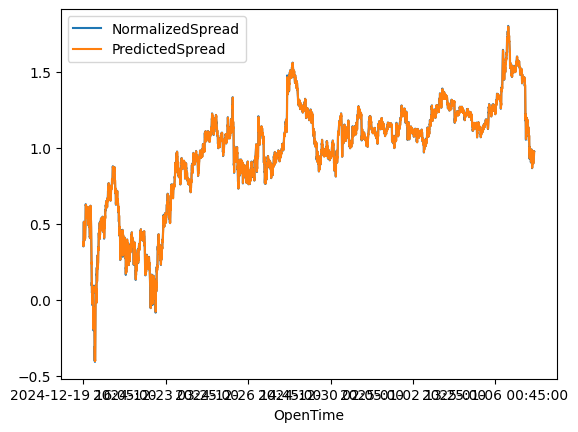

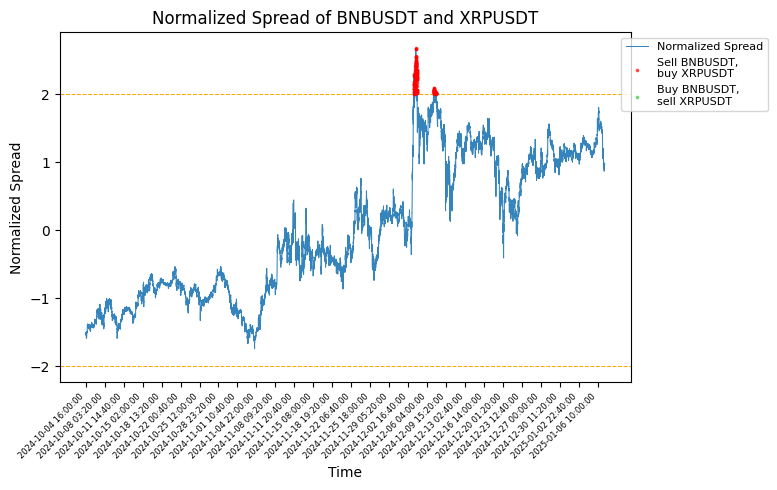

,BNBUSDT,XRPUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.5334,555.7666,-1.525508,No action
2024-10-04 16:05:00,556.5,0.5339,555.9661,-1.521942,No action
2024-10-04 16:10:00,556.0,0.5335,555.4665,-1.530874,No action
2024-10-04 16:15:00,555.9,0.5325,555.3675,-1.532644,No action
2024-10-04 16:20:00,555.5,0.5317,554.9683,-1.539780,No action


Ridge Regression MSE: 7.169350425265582e-05


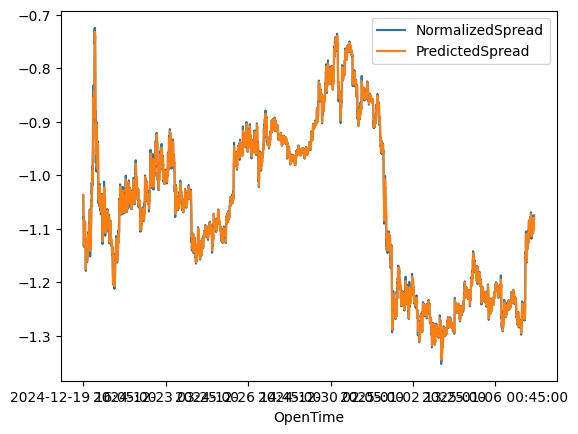

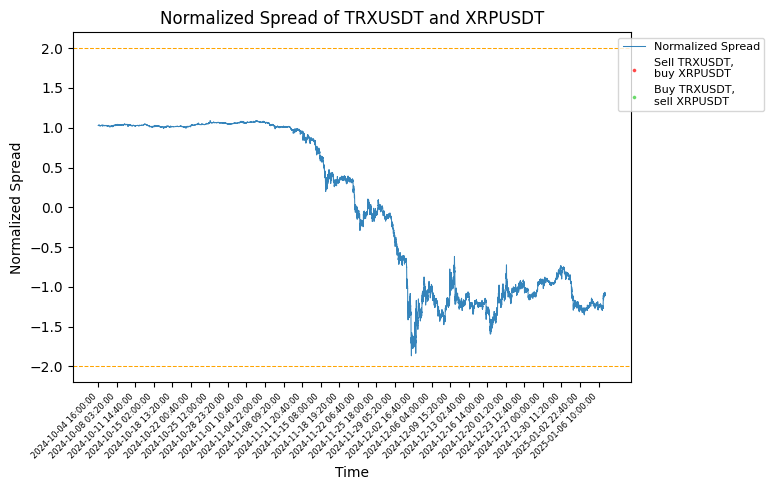

,TRXUSDT,XRPUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,0.1566,0.5334,-0.3768,1.028190,No action
2024-10-04 16:05:00,0.1566,0.5339,-0.3773,1.027548,No action
2024-10-04 16:10:00,0.1566,0.5335,-0.3769,1.028061,No action
2024-10-04 16:15:00,0.1564,0.5325,-0.3761,1.029087,No action
2024-10-04 16:20:00,0.1564,0.5317,-0.3753,1.030114,No action


In [5]:
for p in pairs:
    tickerX, tickerY = p.split(' ')
    spread_df = process_pairs_series(tickerX, tickerY, df=df_full)
    spread_df['Spread'] = spread_df[tickerX] - spread_df[tickerY]
    # Normalize spread
    spread_df['NormalizedSpread'] = ((spread_df['Spread'] - spread_df['Spread'].mean())
                                     / spread_df['Spread'].std())
    # Generate trading signals based on spreads
    spread_df['TradingSignal'] = 'No action'
    spread_df.loc[spread_df['NormalizedSpread']<-2, 'TradingSignal'] = f'Buy {tickerX}, sell {tickerY}'
    spread_df.loc[spread_df['NormalizedSpread']>2, 'TradingSignal'] = f'Buy {tickerY}, sell {tickerX}'

    # Visualize the data
    display(spread_df.head())
    plot_spread(spread_df, tickerX, tickerY)

    model_df = spread_df[['NormalizedSpread']]
    # Create 5 lags
    # To be replaced with/extended by Technical Analysis features
    for lag in range(1, 6):
            model_df[f'NormalizedSpread_Lag{lag}'] = model_df.loc[:, 'NormalizedSpread'].shift(lag)
    model_df = model_df.dropna()
    # Models with default parameters
    ridge, ridge_mse, ridge_test_df = models.ridge_regression(df=model_df)
    xgb, xgb_mse, xgb_test_df = models.xgboost_regression(df=model_df)
    
    # Plot forecasts
    if (ridge_test_df is not None and not ridge_test_df.empty) or \
       (xgb_test_df is not None and not xgb_test_df.empty):
        models.plot_model_forecasts(ridge_test_df, xgb_test_df, tickerX, tickerY)
    
    spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')